In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [2]:
import os
import gc
import random
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb

warnings.filterwarnings('ignore')

class ProjectConfig:
    DATA_PATH = '/kaggle/input/m5-forecasting-accuracy'
    TRAIN_END = 1913
    FORECAST_HORIZON = 28
    RANDOM_STATE = 42
    
    LGB_PARAMS = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'tweedie_variance_power': 1.1,
        'metric': 'rmse',
        'subsample': 0.5,
        'subsample_freq': 1,
        'learning_rate': 0.03,
        'num_leaves': 2047,
        'min_data_in_leaf': 4095,
        'feature_fraction': 0.5,
        'max_bin': 100,
        'n_estimators': 1400,
        'boost_from_average': False,
        'verbose': -1,
        'n_jobs': -1
    }

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(ProjectConfig.RANDOM_STATE)

In [3]:
def downcast_dtypes(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage dropped to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    
    return df

In [4]:
def read_data(path):
    print(f"Reading files from {path}...")
    
    calendar = pd.read_csv(f'{path}/calendar.csv')
    calendar = downcast_dtypes(calendar)
    
    prices = pd.read_csv(f'{path}/sell_prices.csv')
    prices = downcast_dtypes(prices)
    
    sales = pd.read_csv(f'{path}/sales_train_validation.csv')
    sales = downcast_dtypes(sales)
    
    return sales, calendar, prices

In [5]:
df_sales, df_calendar, df_prices = read_data(ProjectConfig.DATA_PATH)

Reading files from /kaggle/input/m5-forecasting-accuracy...
Memory usage dropped to  0.12 Mb (41.9% reduction)
Memory usage dropped to 130.48 Mb (37.5% reduction)
Memory usage dropped to 95.00 Mb (78.7% reduction)


In [7]:
def transform_and_merge(sales, calendar, prices, config):
    for day in range(config.FORECAST_HORIZON):
        sales[f'd_{config.TRAIN_END + day + 1}'] = np.nan

    start_idx = max(1, config.TRAIN_END - 1000) 
    value_cols = [c for c in sales.columns if c.startswith('d_') and int(c.split('_')[1]) >= start_idx]
    
    id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    
    data = pd.melt(sales, id_vars=id_cols, value_vars=value_cols, var_name='d', value_name='sales')
    
    calendar = calendar.drop(['weekday', 'wday', 'month', 'year'], axis=1)
    data = data.merge(calendar, on='d', how='left')
    
    data = data.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    
    del calendar, prices
    gc.collect()
    
    return data

In [8]:
def feature_engineering_basic(df):
    df['d_num'] = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
    
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek.astype(np.int8)
    df['month'] = df['date'].dt.month.astype(np.int8)
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int8)
    
    df['price_momentum'] = df['sell_price'] / df.groupby('id')['sell_price'].transform('mean')
    
    df = df.drop(['date', 'd'], axis=1)
    
    return df

In [9]:
def feature_engineering_lags(df):
    lags = [28, 35, 42, 49, 56]
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('id')['sales'].shift(lag)
        
    windows = [7, 14, 28, 60]
    for win in windows:
        df[f'rolling_mean_{win}'] = df.groupby('id')['lag_28'].transform(
            lambda x: x.rolling(win).mean())
            
    return df

In [15]:
from sklearn.preprocessing import LabelEncoder

def encode_categoricals(df):
    # Added event_name_2 and event_type_2 to the list
    cat_cols = [
        'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 
        'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'
    ]
    
    # Fill NaNs for ALL event columns
    df['event_name_1'] = df['event_name_1'].fillna('NoEvent')
    df['event_type_1'] = df['event_type_1'].fillna('NoEvent')
    df['event_name_2'] = df['event_name_2'].fillna('NoEvent')
    df['event_type_2'] = df['event_type_2'].fillna('NoEvent')
    
    encoder = LabelEncoder()
    for col in cat_cols:
        # We convert to string first to handle any mixed types safely
        df[col] = encoder.fit_transform(df[col].astype(str))
        
    return df

In [16]:
master_df = transform_and_merge(df_sales, df_calendar, df_prices, ProjectConfig)
master_df = downcast_dtypes(master_df)

master_df = feature_engineering_basic(master_df)

master_df = feature_engineering_lags(master_df)

master_df = encode_categoricals(master_df)
master_df = downcast_dtypes(master_df)

master_df.to_pickle('processed_dataset.pkl')

print(f"Dataset shape: {master_df.shape}")

Memory usage dropped to 3141.68 Mb (5.4% reduction)
Memory usage dropped to 1555.88 Mb (62.9% reduction)
Dataset shape: (31374210, 30)


In [17]:
def perform_split(df, config):
    valid_mask = (df['d_num'] > (config.TRAIN_END - config.FORECAST_HORIZON)) & (df['d_num'] <= config.TRAIN_END)
    train_mask = df['d_num'] <= (config.TRAIN_END - config.FORECAST_HORIZON)
    
    X_tr = df[train_mask]
    y_tr = X_tr['sales']
    X_val = df[valid_mask]
    y_val = X_val['sales']
    
    drop_list = ['id', 'sales', 'wm_yr_wk', 'd_num']
    feats = [c for c in df.columns if c not in drop_list]
    
    return X_tr[feats], y_tr, X_val[feats], y_val, feats

In [22]:
def run_lgbm(X_tr, y_tr, X_val, y_val, config):
    dtrain = lgb.Dataset(X_tr, y_tr)
    dvalid = lgb.Dataset(X_val, y_val)
    
    model = lgb.train(
        config.LGB_PARAMS,
        dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(5),
            lgb.log_evaluation(100)
        ]
    )
    
    return model

In [23]:
X_train, y_train, X_valid, y_valid, features = perform_split(master_df, ProjectConfig)

model = run_lgbm(X_train, y_train, X_valid, y_valid, ProjectConfig)

model.save_model('lgbm_model_v1.txt')

Training until validation scores don't improve for 5 rounds
[100]	train's rmse: 2.51916	valid's rmse: 2.16778
[200]	train's rmse: 2.41471	valid's rmse: 2.13267
Early stopping, best iteration is:
[207]	train's rmse: 2.40909	valid's rmse: 2.1319


In [24]:
def predict_forecast(df, model, config, feats):
    pred_mask = df['d_num'] > config.TRAIN_END
    X_test = df[pred_mask][feats]
    
    preds = model.predict(X_test)
    
    output = df[pred_mask][['id', 'd_num']].copy()
    output['sales'] = preds
    
    return output

In [25]:
def format_submission(output_df, config):
    output_df = output_df.pivot(index='id', columns='d_num', values='sales').reset_index()
    
    output_df.columns = ['id'] + [f'F{i}' for i in range(1, config.FORECAST_HORIZON + 1)]
    
    eval_output = output_df.copy()
    eval_output['id'] = eval_output['id'].str.replace('_validation', '_evaluation')
    
    final_sub = pd.concat([output_df, eval_output], axis=0, sort=False)
    
    return final_sub

In [26]:
forecast_df = predict_forecast(master_df, model, ProjectConfig, features)

submission = format_submission(forecast_df, ProjectConfig)

submission.to_csv('submission.csv', index=False)

print("Submission file generated successfully.")
print(submission.head())

Submission file generated successfully.
                            id        F1        F2        F3        F4  \
0  FOODS_1_001_CA_1_validation  0.794222  0.753253  0.782080  0.699344   
1  FOODS_1_001_CA_2_validation  0.790272  0.750621  0.703921  0.688558   
2  FOODS_1_001_CA_3_validation  1.130201  1.108342  1.123899  1.111519   
3  FOODS_1_001_CA_4_validation  0.541773  0.457953  0.466909  0.454834   
4  FOODS_1_001_TX_1_validation  0.405038  0.361766  0.367050  0.360252   

         F5        F6        F7        F8        F9  ...       F19       F20  \
0  0.959818  1.070338  0.969596  0.985943  0.923453  ...  0.876533  1.151813   
1  0.729581  0.896579  0.725079  0.768081  0.773897  ...  0.758491  0.777374   
2  1.128936  1.662966  1.235937  0.951549  0.992924  ...  0.921485  1.193473   
3  0.437278  0.496135  0.468347  0.437585  0.351200  ...  0.320310  0.344327   
4  0.378686  0.409376  0.435868  0.349797  0.400969  ...  0.315491  0.333547   

        F21       F22       F23   

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

def plot_item_forecast(master_df, forecast_df, item_id, config):
    history_mask = (master_df['id'] == item_id) & (master_df['d_num'] <= config.TRAIN_END)
    # Show last 90 days of history for clarity
    history_mask = history_mask & (master_df['d_num'] > config.TRAIN_END - 90)
    history = master_df[history_mask]
    
    forecast = forecast_df[forecast_df['id'] == item_id]
    
    plt.figure(figsize=(14, 7))
    
    plt.plot(history['d_num'], history['sales'], label='Historical Sales (Last 90 Days)', color='#1f77b4', linewidth=2)
    
    plt.plot(forecast['d_num'], forecast['sales'], label='Forecast (Next 28 Days)', color='#ff7f0e', linestyle='--', linewidth=2.5)
    
    plt.axvline(x=config.TRAIN_END, color='grey', linestyle=':', linewidth=1.5, label='Forecast Start')
    
    plt.title(f'Sales Forecast for Item: {item_id}', fontsize=16)
    plt.xlabel('Day Number', fontsize=12)
    plt.ylabel('Sales Volume', fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_results(master_df, forecast_df, config, num_items=3):
    unique_ids = forecast_df['id'].unique()
    random_items = np.random.choice(unique_ids, num_items, replace=False)
    
    for item_id in random_items:
        plot_item_forecast(master_df, forecast_df, item_id, config)

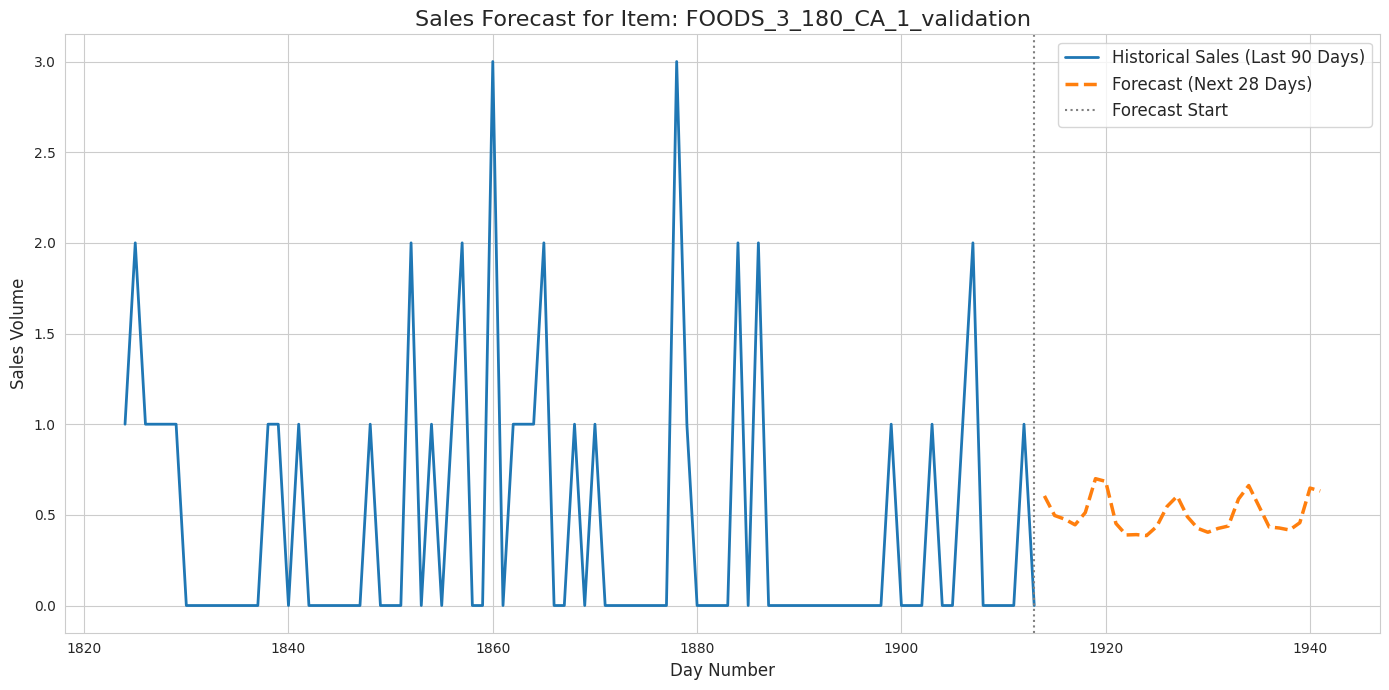

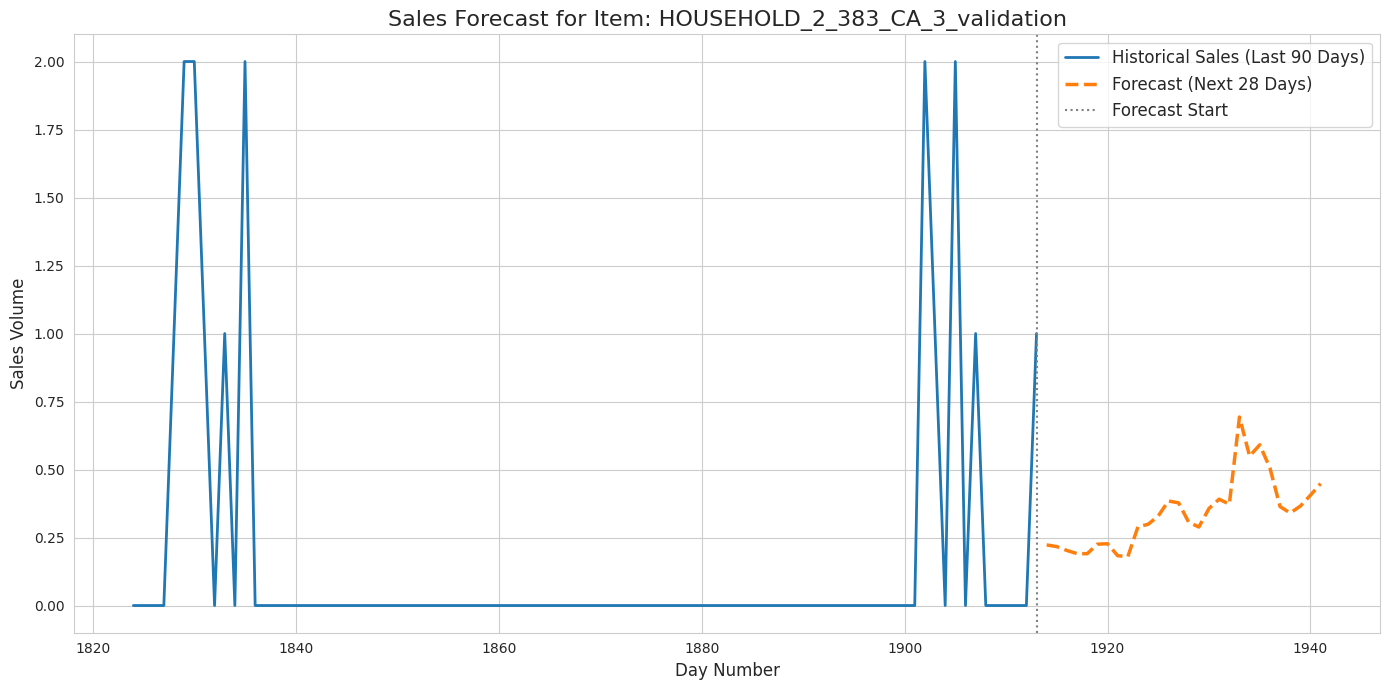

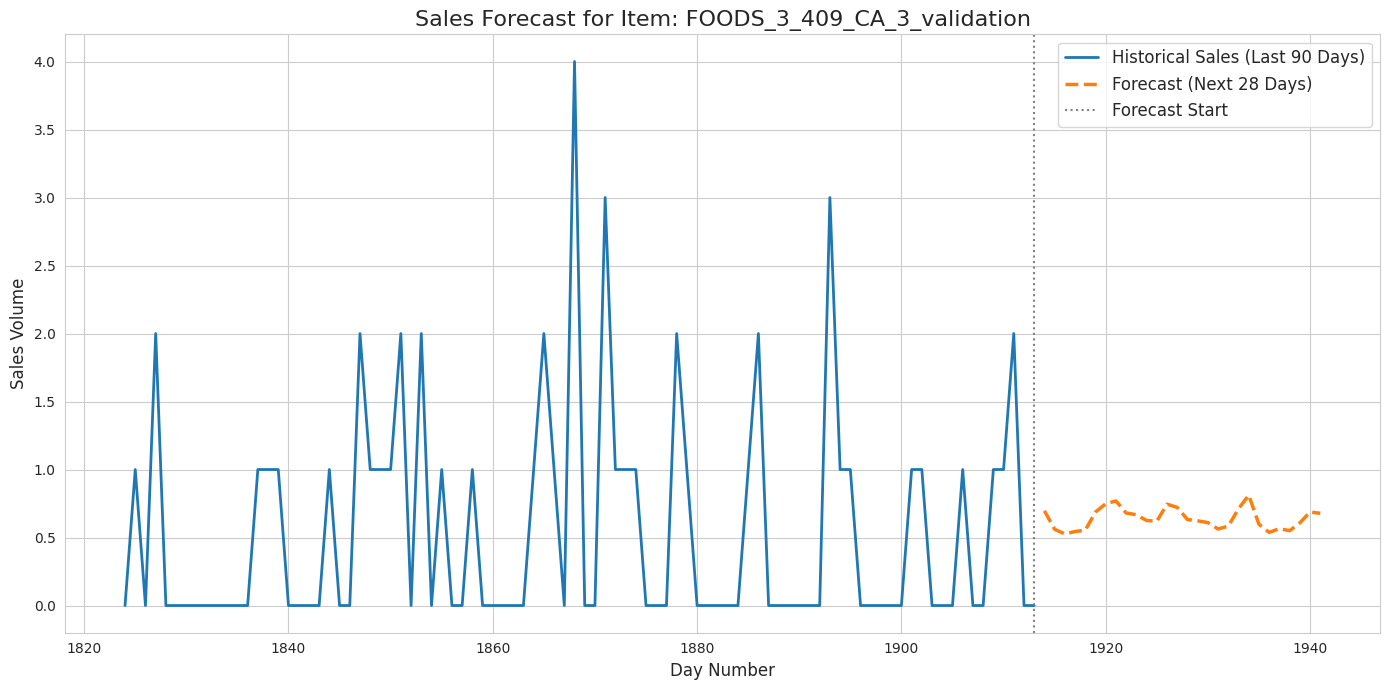

In [28]:
# Ensure you have run all previous sections first
visualize_results(master_df, forecast_df, ProjectConfig, num_items=3)